In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('default')
from matplotlib import rc
rc('text', usetex=True)
import seaborn as sns


import sys, re, time, json
from PSlim import Experiment, get_eps, ROC
from scipy.stats import norm

import sys, os
sys.path = ['nfs/turbo/lsa-enes/bim/bim/', '/home/enes/.conda/envs/gene/lib/python3.8/site-packages'] + sys.path
import pyslim

pyslurm = '/home/enes/pyslurm/'
#pyslurm = None
from Bimbalance import bTree, bSFS
from utils import Colless, Neutrality_Tests
import ruptures as rpt
import tskit

In [2]:
Train = False # False if you do analysis with given simulations and estimates

In [3]:
if pyslurm:
    sys.path.append(pyslurm)
    from pyslurm import Slurm

    slurm = Slurm(account='stats_dept1')

    srun = slurm.batch('source activate slim', 
                       '#time=0-1:00:00',
                       '#mem=1000M',
                       '#mem-per-cpu=None', 
                       '#job-name="sim"')   

    srun_est = slurm.batch('module load python3.8-anaconda/2020.07', 
                           '#mem-per-cpu=300',
                           '#job-name="est"',
                           '#cpus-per-task=3')

### Parameters:

In [4]:
N = 50
Ne = 10000
L = 25_000_000
r = 1.25e-8
mu = 2.5e-8

extmut = 0 # no extra mutation (just one)
Until = 100000 # make sure model runs until it reaches the desired frequency Until>>Ne
h = 0.5

Args = {}

Args['Fn'] = {'Simulator':'slim', 'slimTxt':'Slim.txt', 
              'N':N, 'Ne':Ne, 'L':L, 'r':r, 'mu':mu, 
              's':0, 'h':0.5, 'extmut':0, 'reset_lost': 0,
              'Until':Ne, 'Freq':0.25, 'rep':0, 
              'srun':srun, 'srun_est':srun_est,
              'etapath':'etas/FnX.json', 'start': Until + 100,
              'name':'Neutral Model'}

for s in [0.01]:
    for Freq in [0.75]:
        name = 's='+str(s)+'F='+str(Freq)
        arg = Args['Fn'].copy()
        arg['s'] = s
        arg['Freq'] = Freq
        arg['Until'] = 300000
        arg['name'] = name
        arg['reset_lost'] = 1
        Args[name] = arg

In [5]:
cID = 5# simulation class id for directional selection constant pop size simulations
nrep = 250
X = Experiment(cID, nrep, Args)

# 1 Simulation

In [6]:
if Train:
    X.sim()

# 2 Population Size History estimation

In [7]:
import jax.numpy as jnp
import jax

In [8]:
X.calc_sfs()
X.train_eta()

Done!


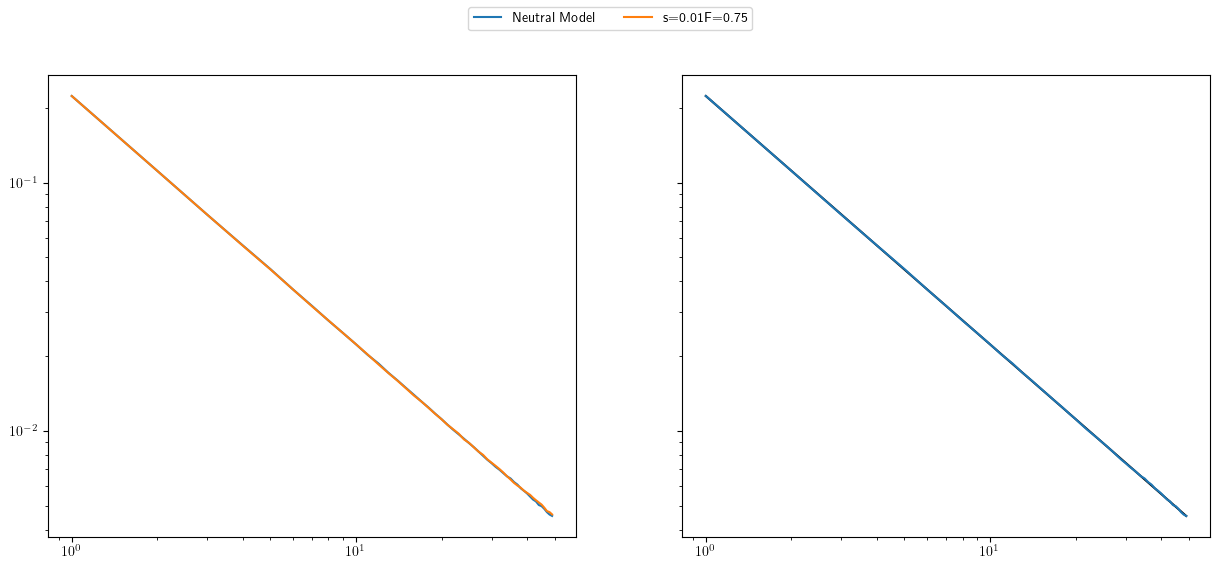

In [9]:
fig, ax = plt.subplots(1,2,figsize = (15,6), sharex=True, sharey=True)

for setid in X.neutrals:
    name = Args[setid]['name']
    ax[1].plot(range(1, len(X.AFS[setid])+1), X.ebl[setid]/X.ebl[setid].sum(), color = 'black')
    ax[1].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum())
    ax[0].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum(), label = name)

for setid in set(X.setids).difference(X.neutrals):
    name = Args[setid]['name']
    ax[0].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum(), label = name)

ax[1].set_xscale('log')
ax[1].set_yscale('log')
fig.legend(ncol = 7, loc = 'upper center')

# 3 Optimizing $\beta$-imbalance and calculating summary stats

In [595]:
BIM = '/nfs/turbo/lsa-enes/bim/bim/BIM.py'
treew = 'split'

if Train:
    for setid in X.setids:
        X.est(BIM, setid, now = 50, srun = srun_est, arg = '--r2t=0.0025 --r2s=0.0025 --wsz=100000 --ssz=25000 --log_pdf=logfr --treew='+treew)

If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!


In [704]:
if Train:
    for setid in X.setids:
        X.merge_outs(setid)

In [6]:
df0 = pd.read_csv(X.df['Fn'])
df1 = pd.read_csv(X.df['s=0.01F=0.75'])

In [7]:
def lag(x, last_lag):
    n = len(x)
    covs = [float(np.cov(x[r:], x[:(n-r)])[0, 1]) for r in range(0, last_lag+1)]
    return np.nan_to_num(covs)

In [8]:
def cpd_genomescan(y, pen):
    algo_c = rpt.KernelCPD(kernel="linear").fit(y/y.std()) 
    result = algo_c.predict(pen = pen)

    result = np.r_[[0], result]

    return np.repeat(np.arange(len(result)-1), np.diff(result))

def cpd_genomescan(y, nbkps):
    algo_c = rpt.KernelCPD(kernel="linear").fit(y/y.std()) 
    result = algo_c.predict(n_bkps = nbkps)

    result = np.r_[[0], result]

    return np.repeat(np.arange(len(result)-1), np.diff(result))

In [9]:
def discoveries(df0, df1, key):
    
    last_lag = df0.groupby('path').size().iloc[0]
    cov = np.array(df0.groupby('path')[key].apply(lambda x: lag(x, last_lag-1)).tolist()).mean(0)
    mu_g = df0[key].mean()
    r = len(cov)
    
    def cF(k):
        if k >= r:
            return 0
        else:
            return cov[k]
        
    def Zscan(x, mu_g, weights = 'uniform'):
        nX = len(x)
        if weights == 'linear':
            w = np.arange(nX)
            w = np.min((nX-w, w+1), 0)
        elif weights == 'uniform':
            w = np.ones(nX)
        elif weights == 'gaussian':
            w = np.arange(1, nX+1)
            m = (nX+1)/2
            w = norm.pdf(5*(w-m)/(nX+1))  
        w = w/w.sum()
        x_bar =  (x*w).sum()
        w2 = w**2
        x_bar_var = w2.sum()*cF(0)
        for i in range(1, nX):
            cW = (w[:-i]*w[i:]).sum()   
            x_bar_var += 2*cF(i)*cW
        sem = np.sqrt(x_bar_var)
        return norm.cdf((x_bar-mu_g)/sem)
    
    dfs = []
    val = False
    
    df = df1            
    cps = []
    segmax = 0
    df['segment'] = 0
    for path in df['path'].unique():
        A = df[df['path'] == path]
        seg = cpd_genomescan(A[key].to_numpy(), 9)
        df.loc[df['path'] == path, 'segment'] = seg + segmax
        segmax += seg.max() + 1  

    df['p'+key] = df[key].copy()
    da = df.groupby(['path', 'segment'], sort = False).agg({'start':'first', 
                                                            'end':'last', 
                                                            'p'+key:lambda x: Zscan(x, mu_g),
                                                            key:'mean'}).reset_index()
    da['Selection'] = False

    mut = L//2
    st = mut - 250_000
    en = mut + 250_000
    
    start = da['start']
    end = da['end']
    
    op1 = (st>=start) & (end>st)
    op2 = (st<=start) & (start<en)
    
    da.loc[op1|op2, 'Selection'] = True

    return da   

In [10]:
def f(x, ps, alt = '>'):
    if alt == '<':
        return (x.to_numpy()<ps[:, None]).sum(1)
    elif alt == '>':
        return (x.to_numpy()>(1-ps[:, None])).sum(1)
    else:
        raise ValueError('wow')

In [11]:
stats = ['bsfs', 'TajD', 'ibtree', 'iColless', 'iOmega']
hyp = ['<', '<', '<', '>', '<']

In [12]:
mycolors = cm.get_cmap('tab20').colors
color = {stats[i]:[mycolors[2*i], mycolors[2*i+1]] for i in range(len(stats))}

In [13]:
ps = np.logspace(-2, -14, 2500)       
dstats = []
dscans = {}

for alt, key in zip(hyp, stats):

    dfs = discoveries(df0, df1, key)
    
    dfs['color'] = [color[key][0] if i else color[key][1] for i in dfs['Selection']]    
    ns = dfs.groupby('Selection').size().tolist()

    dsel = pd.DataFrame(dfs.groupby('Selection')['p'+key].apply(lambda x: f(x, ps, alt)).to_dict())
    dsel['p'] = ps
    dsel = dsel.melt(id_vars = 'p', value_vars=[True, False]).sort_values(['p', 'variable']).reset_index(drop = True)
    dsel['percent'] = dsel['value']/np.tile(ns, dsel.shape[0]//2)
    dsel['stat'] = key

    dstats.append(dsel)
    dscans[key] = dfs
dstats = pd.concat(dstats)

dscans['iColless']['piColless'] = 1 - dscans['iColless']['piColless']

<ipython-input-7-77f81b085d87>:3: RuntimeWarning: Degrees of freedom <= 0 for slice
  covs = [float(np.cov(x[r:], x[:(n-r)])[0, 1]) for r in range(0, last_lag+1)]
/home/enes/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/enes/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [60]:
stat = 'bsfs'

da = dscans[stat]
da = da[~da['Selection']]
np.mean(da['p'+stat]<(0.005))

0.37650130548302874

0.37650130548302874

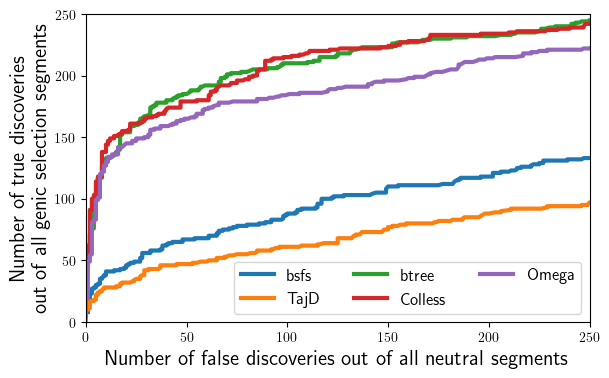

In [19]:
var = 'value'

plt.figure(figsize = (6.5, 4))
for key in stats:
    
    if key[0] == 'i':
        stat = key[1:]
    else:
        stat = key
    
    x = dstats[dstats['stat'] == key][['p', 'variable', var]].pivot('p', 'variable', var)
    plt.plot(x[False], x[True], label = stat, color = color[key][0], linewidth = 3)    
    
plt.xlim((0, 250))
plt.ylim((0, 250))
plt.legend(ncol = 3, prop={'size': 12})


plt.xlabel('Number of false discoveries out of all neutral segments', size = 15)
plt.ylabel('Number of true discoveries\nout of all genic selection segments', size = 15)
plt.savefig('plots/Genomescan_simulation_ROC.pdf', dpi = 300)

In [32]:
mut = L//2
st = mut - 250_000
en = mut + 250_000

thres = 0.05/2.5e7

In [46]:
dstats[dstats['stat'] == key]

,p,variable,value,percent,stat
0,1.000000e-14,False,0,0.000000,iOmega
1,1.000000e-14,True,4,0.006070,iOmega
2,1.011118e-14,False,0,0.000000,iOmega
3,1.011118e-14,True,4,0.006070,iOmega
4,1.022360e-14,False,0,0.000000,iOmega
...,...,...,...,...,...
4995,9.781291e-03,True,303,0.459788,iOmega
4996,9.890041e-03,False,654,0.355242,iOmega
4997,9.890041e-03,True,304,0.461305,iOmega
4998,1.000000e-02,False,655,0.355785,iOmega


In [37]:
var = 'value'
dstats[dstats['stat'] == key]

,p,variable,value,percent,stat
0,1.000000e-14,False,0,0.000000,TajD
1,1.000000e-14,True,0,0.000000,TajD
2,1.011118e-14,False,0,0.000000,TajD
3,1.011118e-14,True,0,0.000000,TajD
4,1.022360e-14,False,0,0.000000,TajD
...,...,...,...,...,...
4995,9.781291e-03,True,130,0.274841,TajD
4996,9.890041e-03,False,519,0.256043,TajD
4997,9.890041e-03,True,132,0.279070,TajD
4998,1.000000e-02,False,522,0.257523,TajD


In [38]:
ds

,path,segment,start,end,pTajD,TajD,Selection,color
0,5010000,0,0,5850000,0.118832,-0.042875,False,"(1.0, 0.7333333333333333, 0.47058823529411764)"
1,5010000,1,5775000,6200000,0.989049,0.400602,False,"(1.0, 0.7333333333333333, 0.47058823529411764)"
2,5010000,2,6125000,15850000,0.016723,-0.055157,True,"(1.0, 0.4980392156862745, 0.054901960784313725)"
3,5010000,3,15775000,16000000,0.980801,0.497793,False,"(1.0, 0.7333333333333333, 0.47058823529411764)"
4,5010000,4,15925000,17400000,0.001154,-0.271334,False,"(1.0, 0.7333333333333333, 0.47058823529411764)"
...,...,...,...,...,...,...,...,...
2495,5010249,2495,15575000,17500000,0.513130,0.009246,False,"(1.0, 0.7333333333333333, 0.47058823529411764)"
2496,5010249,2496,17425000,18500000,0.001305,-0.316528,False,"(1.0, 0.7333333333333333, 0.47058823529411764)"
2497,5010249,2497,18425000,18825000,0.980655,0.373196,False,"(1.0, 0.7333333333333333, 0.47058823529411764)"
2498,5010249,2498,18750000,21125000,0.000694,-0.219002,False,"(1.0, 0.7333333333333333, 0.47058823529411764)"


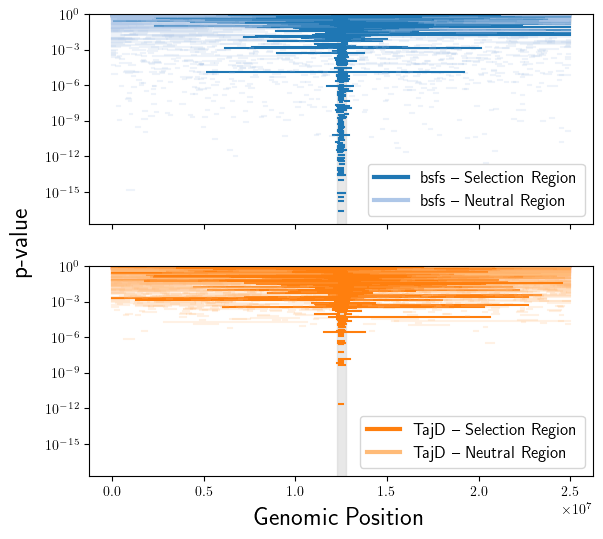

In [42]:
fig, ax = plt.subplots(2,1, figsize = (6.5, 3*2), sharex = True)

for _, key in enumerate(['bsfs', 'TajD']):
    ax[_].fill_between([st, en], [1e-50, 1e-50], [1, 1], color='lightgray', alpha=0.5)
    
    ds = dscans[key] 
    ds['trans'] = [1 if i else 0.2 for i in ds['Selection']]  
    
    #ds = ds.sort_values('Selection').reset_index(drop = True)

    for i in range(ds.shape[0]):
        x = [ds['start'].iloc[i], ds['end'].iloc[i]]
        y = 2*[ds['p'+key].iloc[i]]
        c = ds['color'].iloc[i]
        t = ds['trans'].iloc[i]
                
        ax[_].plot(x, y, color = c, alpha = t)
                
    if key[0] == 'i':
        stat = key[1:]
    else:
        stat = key
                    
    ax[_].plot(0, 0, color = color[key][0], label = stat +' -- Selection Region', linewidth = 3)
    ax[_].plot(0, 0, color = color[key][1], label = stat +' -- Neutral Region', linewidth = 3)  
                    
    ps = dscans[key]['p'+key]
    ps = ps[ps>0]
    ax[_].legend(loc = 'lower right', prop={'size': 12})
    ax[_].set_ylim(2e-18, 1)
    ax[_].set_yscale('log')

fig.text(0.51, 0.04, 'Genomic Position', ha='center', va='center', size = 18)
fig.text(0.02, 0.5, 'p-value', rotation = 90, ha='center', va='center', size = 18)
plt.savefig('plots/Genomescan_simulation_maintext.pdf', dpi = 600, bbox_inches = 'tight')

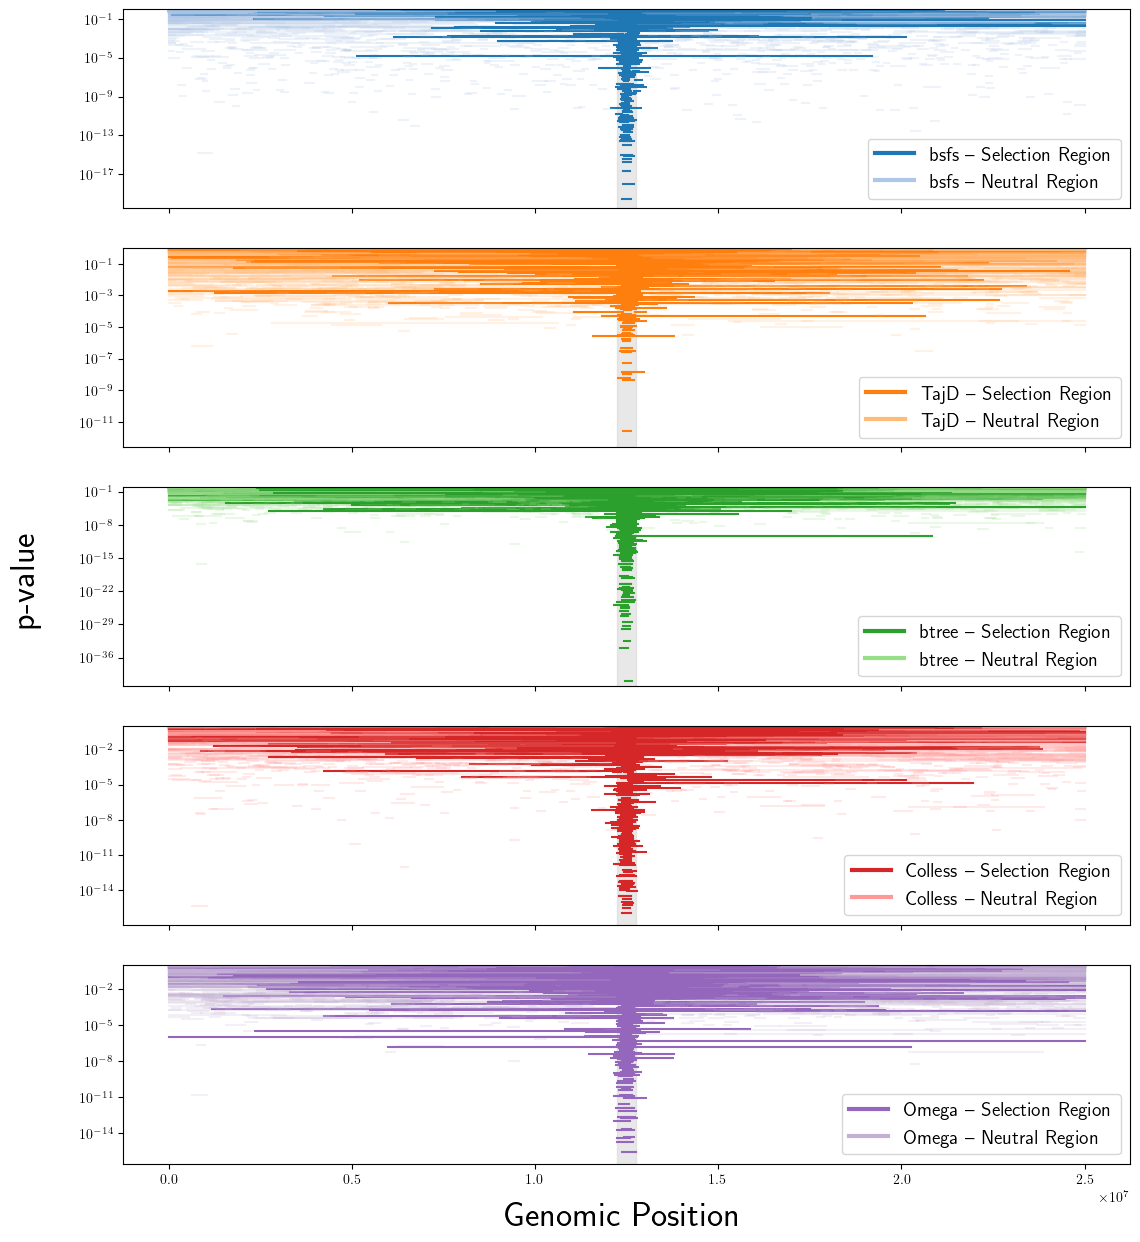

In [45]:
fig, ax = plt.subplots(5,1, figsize = (13, 3*5), sharex = True)


for _, key in enumerate(stats):
    ax[_].fill_between([st, en], [1e-50, 1e-50], [1, 1], color='lightgray', alpha=0.5)

    ds = dscans[key]    
    #ds = ds.sort_values('Selection').reset_index(drop = True)
    ds['trans'] = [1 if i else 0.2 for i in ds['Selection']]  

    for i in range(ds.shape[0]):
        x = [ds['start'].iloc[i], ds['end'].iloc[i]]
        y = 2*[ds['p'+key].iloc[i]]
        t = ds['trans'].iloc[i]
        c = ds['color'].iloc[i]
                
        ax[_].plot(x, y, color = c, alpha = t)
                
    if key[0] == 'i':
        stat = key[1:]
    else:
        stat = key
                    
    ax[_].plot(0, 0, color = color[key][0], label = stat +' -- Selection Region', linewidth = 3)
    ax[_].plot(0, 0, color = color[key][1], label = stat +' -- Neutral Region', linewidth = 3)  
                    
    ps = dscans[key]['p'+key]
    ps = ps[ps>0]
    ax[_].legend(loc = 'lower right', prop={'size': 14})
    ax[_].set_ylim(ps.min()*0.1, 1)
    ax[_].set_yscale('log')

fig.text(0.51, 0.075, 'Genomic Position', ha='center', va='center', size = 25)
fig.text(0.05, 0.5, 'p-value', rotation = 90, ha='center', va='center', size = 25)
plt.savefig('plots/Genomescan_simulation.pdf', dpi = 600, bbox_inches = 'tight')

## Don't Run

In [104]:
btree = bTree(N, rho2 = 0.005)

until = 20000
s = 0.002

xbtree = []
ybtree = []
numroots = []
rootstart = []


for simID in tqdm(X.simIDs['s=0.001F=0.75']):
    ts = pyslim.load('/scratch/stats_dept_root/stats_dept1/enes/trees/'+str(simID)+'.trees')
    numroots.append([t.num_roots for t in ts.trees()])
    rootstart.append(list(ts.breakpoints())[:-1])
    
    ts = recap(ts, Ne = Ne, r = r, SEED = simID)
    ts = ts.delete_sites([m.site for m in ts.mutations()])
    ts = mutate(ts, mu = mu, SEED = simID)
    ts = subsample(ts, N, SEED = simID)

    dfbtree = []
    trees = ts.trees()
    ntrees = ts.num_trees
    for i in range(ntrees):
        Tree = next(trees)
        bls = np.array([Tree.time(i) for i in Tree.nodes(order = 'timedesc') if Tree.is_internal(i)]+[0])
        bls = bls[:-1]-bls[1:]
        bls = np.r_[bls, np.zeros(N-1-len(bls))]
                
        tst, ten = Tree.interval
        n, k = btree.tree_to_splits(Tree)['splits']
        
        ktk = np.flip(np.arange(2, N+1)*bls)
        
        ret = {'start':tst, 'end':ten, 'btree': float(btree.predict(n, k, n-2).x), 'Colless':abs(n[-1]-2*k[-1])}
        dfbtree.append(ret)
    dfbtree = pd.DataFrame(dfbtree)
    
    xbtree.append(dfbtree['start'])
    ybtree.append(dfbtree['btree'])

Text(0, 0.5, 'number of roots')

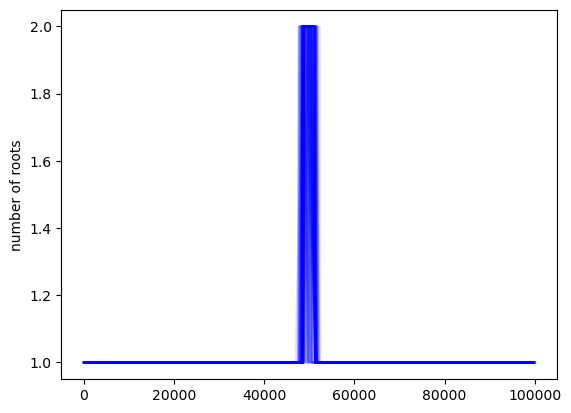

In [44]:
for xi, yi in zip(rootstart, numroots):
    plt.plot(xi, yi, color = 'blue', alpha = 0.1)
plt.ylabel('number of roots')

In [73]:
k = np.arange(N, 1, -1)
k

array([250, 249, 248, 247, 246, 245, 244, 243, 242, 241, 240, 239, 238,
       237, 236, 235, 234, 233, 232, 231, 230, 229, 228, 227, 226, 225,
       224, 223, 222, 221, 220, 219, 218, 217, 216, 215, 214, 213, 212,
       211, 210, 209, 208, 207, 206, 205, 204, 203, 202, 201, 200, 199,
       198, 197, 196, 195, 194, 193, 192, 191, 190, 189, 188, 187, 186,
       185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174, 173,
       172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161, 160,
       159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147,
       146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134,
       133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121,
       120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108,
       107, 106, 105, 104, 103, 102, 101, 100,  99,  98,  97,  96,  95,
        94,  93,  92,  91,  90,  89,  88,  87,  86,  85,  84,  83,  82,
        81,  80,  79,  78,  77,  76,  75,  74,  73,  72,  71,  7

Text(0, 0.5, 'btree')

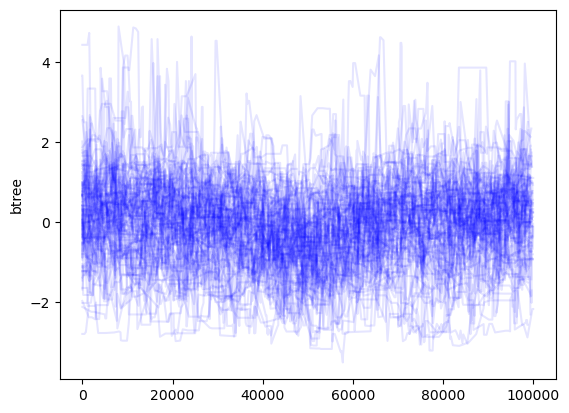

In [105]:
for xi, yi in zip(xbtree, ybtree):
    plt.plot(xi, yi, color = 'blue', alpha = 0.1)
plt.ylabel('btree')

In [20]:
bsfs = bSFS(N, rho2 = 0.01)

In [53]:
Ne

1000

In [22]:
xbsfs = []
ybsfs = []

for simID in tqdm(X.simIDs['until='+str(until)+'s='+str(s)]):
    ts = pyslim.load('/scratch/stats_dept_root/stats_dept1/enes/trees/'+str(simID)+'.trees')

    ts = recap(ts, Ne = Ne, r = r, SEED = simID)
    ts = ts.delete_sites([m.site for m in ts.mutations()])
    ts = mutate(ts, mu = mu, SEED = simID)
    ts = subsample(ts, N, SEED = simID)
    
    SFS, df, starts, ends = slidingSFS(ts, wsz = 2500, ssz = 1250)
    
    dfbsfs = []
    for i in range(SFS.shape[0]):
        sfs = SFS[i]
        SS = sfs.sum() 

        start = df['start'].iloc[i]
        end = df['end'].iloc[i]
        ret = {'start':start, 'end':end, 'SS':SS}
        if SS == 0:
            ret['bsfs'] = 0.
        else:
            ret['bsfs'] = bsfs.predict(sfs).x[0]
        dfbsfs.append(ret)
    dfbsfs = pd.DataFrame(dfbsfs)
    
    xbsfs.append(dfbsfs['start'])
    ybsfs.append(dfbsfs['bsfs'])
    

Text(0, 0.5, 'bsfs')

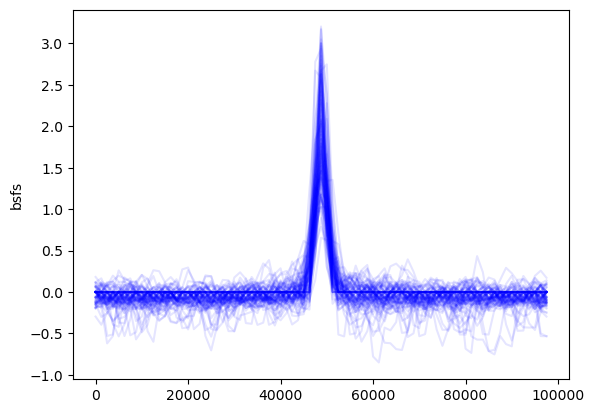

In [26]:
for xi, yi in zip(xbsfs, ybsfs):
    plt.plot(xi, yi, color = 'blue', alpha = 0.1)
plt.ylabel('bsfs')

In [12]:
ts = pyslim.load('/scratch/stats_dept_root/stats_dept1/enes/trees/5050001.trees')

ts = subsample(ts, 30, SEED = 42)

In [326]:
ts

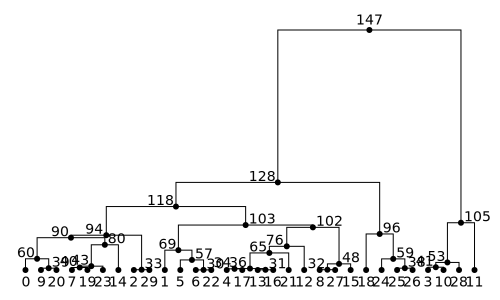

In [325]:
from IPython.display import SVG, display
SVG(ts.first().draw_svg(size = (500, 300)))

In [276]:
ts = pyslim.load('/scratch/stats_dept_root/stats_dept1/enes/trees/5050001.trees')
ts = subsample(ts, 30, SEED = 42)

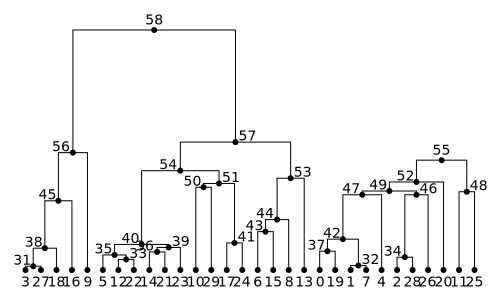

In [277]:
from IPython.display import SVG, display
ts = ts.delete_sites([m.site for m in ts.mutations()]) 
SVG(ts.first().draw_svg(size = (500, 300)))

In [51]:
bls = np.array([Tree.time(i) for i in Tree.nodes(order = 'timedesc') if Tree.is_internal(i)]+[0])
bls = bls[:-1]-bls[1:]

In [52]:
bls

array([322.,   2.,  12.,  17.,  38.,  24.,   9.,   5.,   5.,  13.,   3.,
         4.,   2.,   7.,   4.,   2.,   2.,   1.,   2.,   0.,   1.,   0.,
         2.,   1.,   1.,   7.,   1.,   3.,   1.,   1.,   1.,   2.,   3.,
         0.,   1.,   1.,   1.,   0.,   1.,   0.,   1.,   1.,   1.,   1.,
         1.,   1.,   0.,   1.,   0.,   2.,   0.,   1.,   0.,   0.,   0.,
         0.,   1.,   0.,   1.,   1.,   1.,   0.,   0.,   1.,   0.,   1.,
         0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
         0.,   0.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,
         0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
         0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
         0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
         0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         1.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [110]:
simID = 42
ts = recap(ts, Ne = Ne, r = r, SEED = simID)
ts = mutate(ts, mu = mu, SEED = simID)
ts = subsample(ts, N, SEED = simID)


AttributeError: 'TreeSequence' object has no attribute 'recapitate'

In [111]:
ts.dump('Experiment.trees')

In [14]:
BIM = '/home/enes/bim/BIM.py'

In [15]:
tree = '/scratch/stats_dept_root/stats_dept1/enes/trees/5050001.trees'

In [26]:
! python {BIM} Experiment.trees 50 --out=Experiment.csv --treew=branch

2021-05-10 11:54:23.412303: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /sw/arcts/centos7/python3.8-anaconda/2020.07/lib:/opt/slurm/lib64::
2021-05-10 11:54:23.493206: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /sw/arcts/centos7/python3.8-anaconda/2020.07/lib:/opt/slurm/lib64::
2021-05-10 11:54:23.868105: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /sw/arcts/centos7/python3.8-anaconda/2020.07/lib:/opt/slur

In [27]:
df = pd.read_csv('Experiment.csv', comment = '#')
df

,start,end,N,SS,FayH,TajD,FerL,FulD,ZngE,bsfs,Colless,btree,path
0,0,100001.0,50,385,0.029739,0.321123,0.061518,0.093407,0.11178,0.555437,0.11337,-0.072031,Experiment.trees


In [21]:
df = pd.read_csv('Experiment.csv', comment = '#')
df

,start,end,N,SS,TajD,bsfs,FulD,FayH,FerL,ZngE,btree,Colless,path
0,0,100001.0,50,385,0.321123,0.555437,0.093407,0.029739,0.061518,0.11178,0.107085,0.11337,Experiment.trees


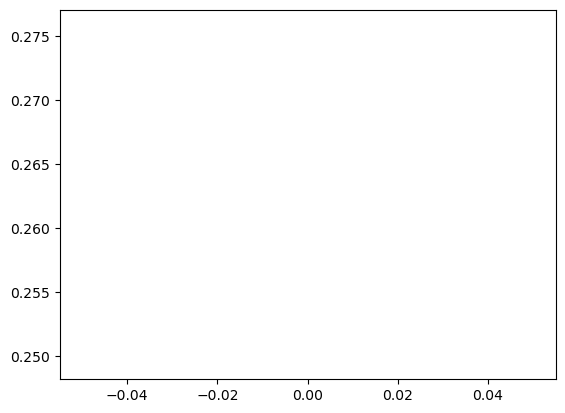

In [116]:
plt.plot(df['start'], df['btree'])

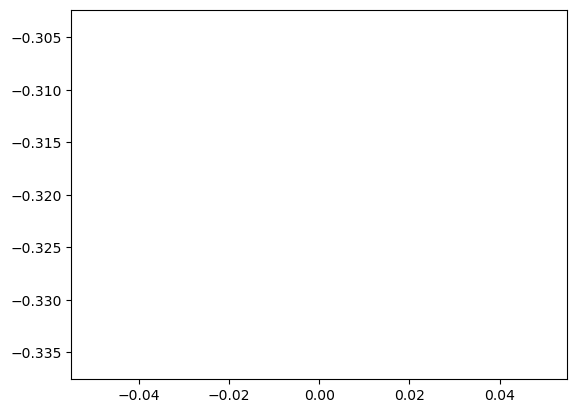

In [117]:
plt.plot(df['start'], df['bsfs'])

In [118]:
a = next(ts.mutations())

In [119]:
pos = [a.position for a in ts.mutations()]

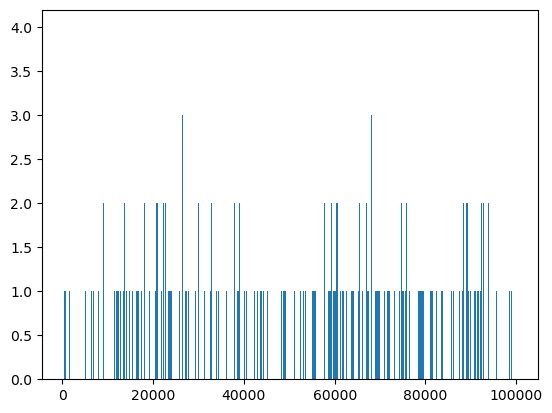

In [120]:
plt.hist(pos, bins = 1000)
plt.show()











## 2 Population Size History estimation

In [121]:
X.calc_sfs()
X.train_eta()

Done!


Fn 110746
s=0.02F=0.25 107338
s=0.001F=0.75 106706
s=0.01F=0.25 107488
s=0.001F=0.25 113179
s=0.01F=0.75 91270
s=0.001F=0.5 109863
s=0.003F=0.5 105742
s=0.02F=0.5 98463
s=0.003F=0.75 101232
s=0.02F=0.75 88816
s=0.003F=0.25 110252
s=0.01F=0.5 101608


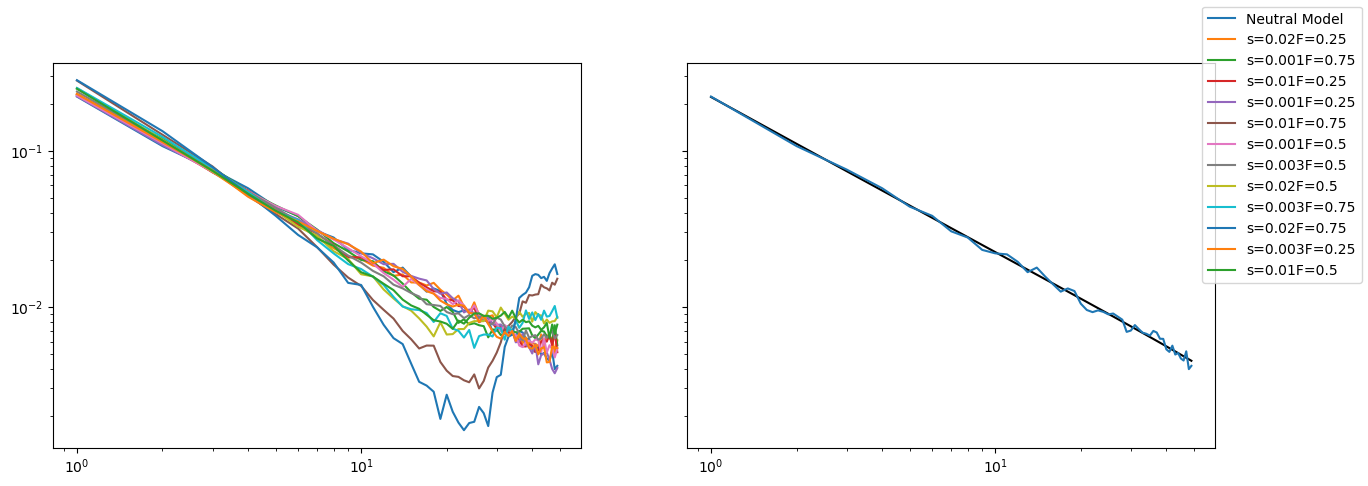

In [122]:
fig, ax = plt.subplots(1,2,figsize = (15,5), sharex=True, sharey=True)

for setid in X.neutrals:
    name = Args[setid]['name']
    ax[1].plot(range(1, len(X.AFS[setid])+1), X.ebl[setid]/X.ebl[setid].sum(), color = 'black')
    ax[1].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum())
    ax[0].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum(), label = name)
    print(setid, X.AFS[setid].sum())
    
for setid in set(X.setids).difference(X.neutrals):
    name = Args[setid]['name']
    ax[0].plot(range(1, len(X.AFS[setid])+1), X.AFS[setid]/X.AFS[setid].sum(), label = name)
    print(setid, X.AFS[setid].sum())

ax[1].set_xscale('log')
ax[1].set_yscale('log')
fig.legend()

## 3 Optimizing $\beta$-imbalance and calculating summary stats

In [123]:
BIM = '/home/enes/bim/BIM.py'

estjobs = {}
if Train:
    for setid in X.setids:
        estjobs[setid] = X.est(BIM, setid, now = 20, srun = srun_est, arg = '--r2t=0.005 --r2s=0.005')

If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!
If you are using HPC (srun is not None) check the jobs!


In [124]:
if Train:
    for setid in X.setids:
        X.merge_outs(setid)

FileNotFoundError: [Errno 2] File outs/386433220.csv does not exist: 'outs/386433220.csv'

## 4 Analysis

In [ ]:
stats = ['bsfs', 'TajD', 'btree', 'ibtree', 'Colless']
myorder = [2, 3, 0, 1, 4]
aucs = {stat:[] for stat in stats}

### ROC Curves

Text(0.05, 0.5, 'True Positive Rates')

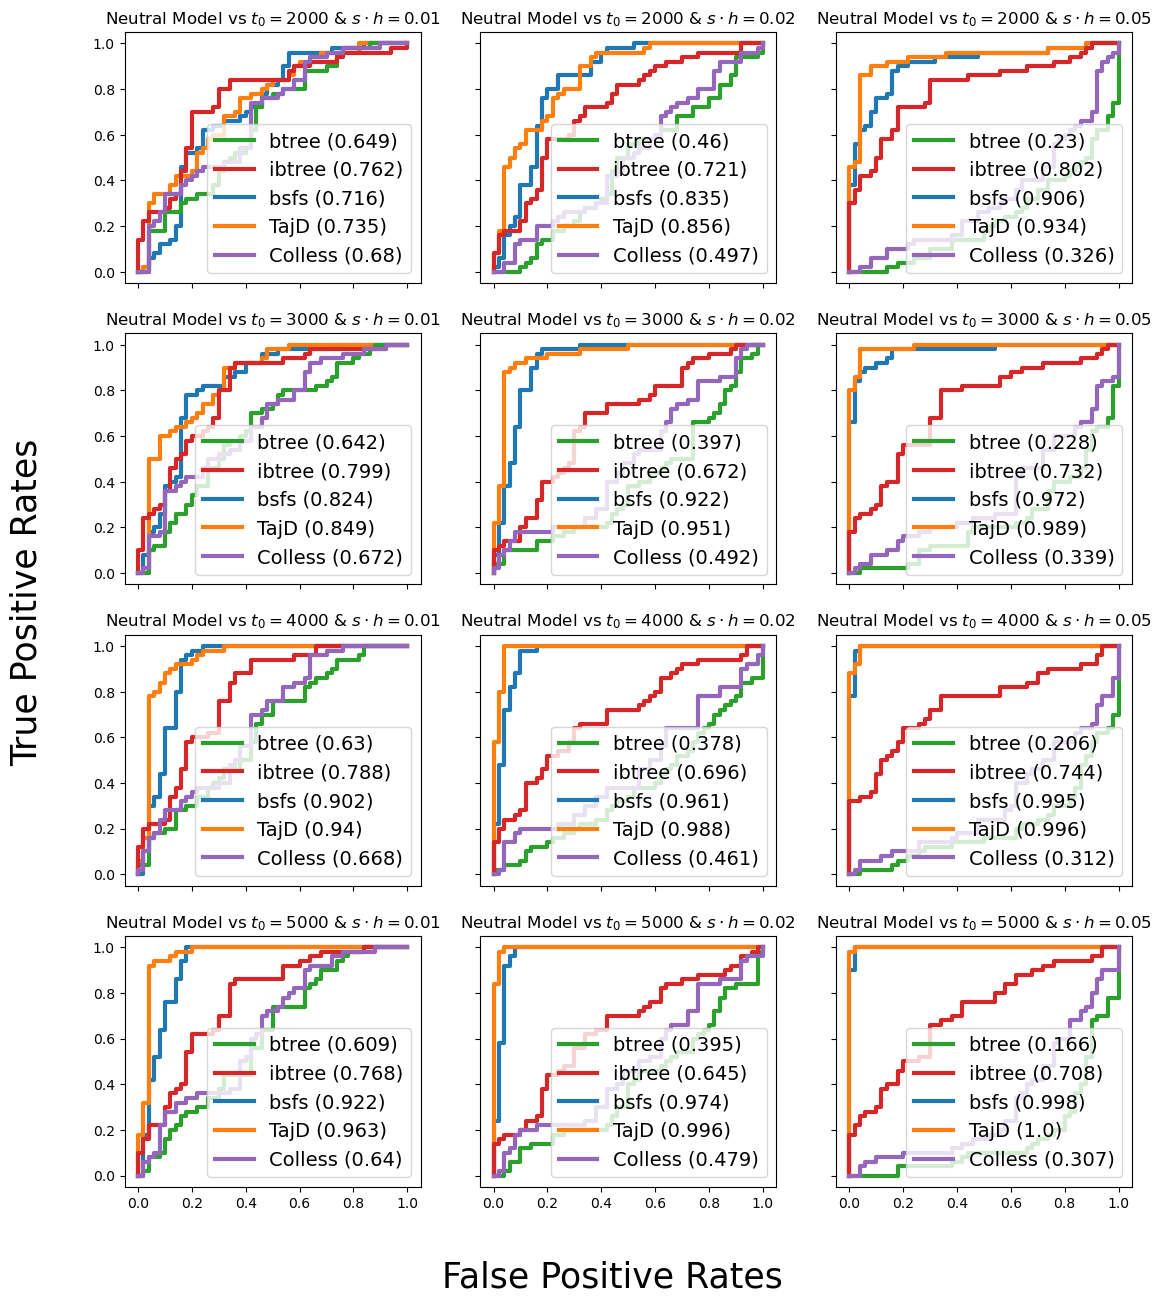

In [308]:
fig, ax = plt.subplots(4,3,figsize = (13,15), sharex = True, sharey = True)

for j, Until in enumerate([2000, 3000, 4000, 5000]):
        
    Vs = [['Neut', 'until='+str(Until)+'s='+str(s)] for s in [0.01/h, 0.02/h, 0.05/h]]
    names = [['Neutral Model', '$t_0='+str(Until)+'$ & $s\cdot h='+str(s*h)+'$'] for s in [0.01/h, 0.02/h, 0.05/h]]
    
    for i, vs in zip(range(len(Vs)), Vs):
        for key in stats:
            k1, k2 = vs
            df1 = pd.read_csv(X.df[k1])
            df2 = pd.read_csv(X.df[k2])
            for pos in ['Colless', 'FulD']:
                df1[pos] = -df1[pos]
                df2[pos] = -df2[pos]

            auc = ROC(ax[j, i], df1[key], df2[key], score_ascending = True, label = key)
            aucs[key].append(auc)
            
            
        handles, labels = ax[j,i].get_legend_handles_labels()
        ax[j, i].legend([handles[_] for _ in myorder], [labels[_] for _ in myorder], loc = 'lower right',
                       prop={'size': 14})

            
    for i, vs in zip(range(len(Vs)), Vs):
        k1, k2 = vs
        ax[j, i].set_title(names[i][0]+' vs '+names[i][1])
        
fig.text(0.5, 0.05, 'False Positive Rates', ha='center', va='center', size = 25)
fig.text(0.05, 0.5, 'True Positive Rates', rotation = 90, ha='center', va='center', size = 25)

### Box plots

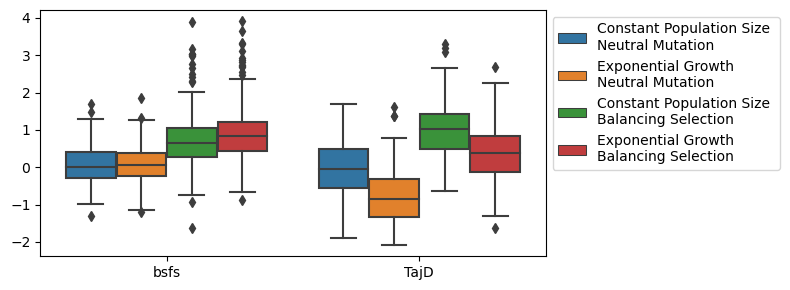

In [23]:
dfs = []
for setid in X.setids:
    df = pd.read_csv(X.df[setid])[['path']+stats]
    df['setid'] = Args[setid]['name']
    dfs.append(df)
    
dfs = pd.concat(dfs)
dfs = dfs.melt(id_vars=['path', 'setid'], var_name='stats', value_name='values')

plt.figure(figsize = (8,3))

sns.boxplot(data=dfs, x='stats', y='values', hue='setid')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig('plots/Exponential_Balancing_box.jpg', dpi = 300)